<a href="https://colab.research.google.com/github/soy-min/climate-prognosis/blob/main/ClimatePrognosis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [228]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM

Globale Parameter

In [229]:
START_YEAR_OBSERVATION='1995-01-01'
OBSERVATION_LOCATION_NAME='DEFAULT'

CSV laden

In [230]:
# Laden der CSV-Datei
#df = pd.read_csv('SW000002361.csv')
df = pd.read_csv('USC00122825.csv')
OBSERVATION_LOCATION_NAME=df.iloc[1]['NAME']
print(df.head())

       STATION     DATE  LATITUDE  LONGITUDE  ELEVATION  \
0  USC00122825  1893-01   40.2538   -85.1484      294.1   
1  USC00122825  1893-02   40.2538   -85.1484      294.1   
2  USC00122825  1893-04   40.2538   -85.1484      294.1   
3  USC00122825  1893-05   40.2538   -85.1484      294.1   
4  USC00122825  1893-06   40.2538   -85.1484      294.1   

                    NAME  CDSD  CDSD_ATTRIBUTES  CLDD CLDD_ATTRIBUTES  ...  \
0  FARMLAND 5 NNW, IN US   0.0              6.0   0.0              ,6  ...   
1  FARMLAND 5 NNW, IN US   0.0              6.0   0.0             2,6  ...   
2  FARMLAND 5 NNW, IN US   NaN              NaN   5.3              ,6  ...   
3  FARMLAND 5 NNW, IN US   NaN              NaN   9.7              ,6  ...   
4  FARMLAND 5 NNW, IN US   NaN              NaN   NaN             NaN  ...   

    SNOW SNOW_ATTRIBUTES   TAVG TAVG_ATTRIBUTES   TMAX TMAX_ATTRIBUTES   TMIN  \
0    NaN             NaN  -8.37              ,6  -3.54            ,,,6 -13.20   
1    NaN      

Reduzieren auf relevante Informationen

In [231]:
# Auswahl der relevanten Spalten (z.B. Datum, Temperatur)
df = df[['DATE', 'TAVG']]
# Umbenennen der Spalten
df = df.rename(columns={'DATE': 'date', 'TAVG': 'temp'})
# Festlegen des Indexes als Datum
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
# reduzieren auf > START_YEAR_OBSERVATION
df=df.loc[START_YEAR_OBSERVATION:]
# einblick in die Daten
df

,temp
date,
1995-01-01,-2.44
1995-02-01,-2.88
1995-03-01,4.89
1995-04-01,8.84
1995-05-01,14.64
...,...
2022-11-01,5.68
2022-12-01,-1.25
2023-01-01,1.82


Visualisieren der Daten

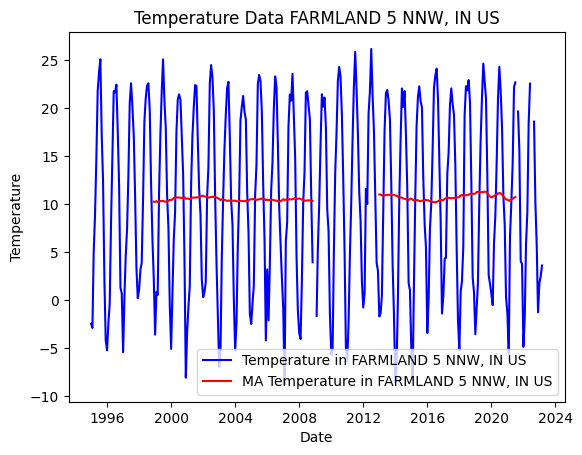

In [232]:
# Plotten der Ergebnisse
plt.plot(df.index, df['temp'], color='blue', label='Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df.index, df.rolling(window=48).mean()['temp'], color='red', label='MA Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Temperature Data '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Trainings und Testdaten separieren

In [233]:
# Teilen der Daten in Trainings- und Testdaten
train, test = train_test_split(df, test_size=0.2, shuffle=False)
# Ergebnis einsehen
test

,temp
date,
2017-07-01,22.04
2017-08-01,20.44
2017-09-01,19.28
2017-10-01,14.12
2017-11-01,5.32
...,...
2022-11-01,5.68
2022-12-01,-1.25
2023-01-01,1.82


Normierung auf Werte 0..1

In [234]:
# Skalieren der Daten
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
# Ergebnis einsehen
test_scaled

array([[0.88243707],
       [0.83667048],
       [0.8034897 ],
       [0.65589245],
       [0.4041762 ],
       [0.19193364],
       [0.10354691],
       [0.27831808],
       [0.3083524 ],
       [0.40989703],
       [0.8020595 ],
       [0.88930206],
       [0.87643021],
       [0.90732265],
       [0.84038902],
       [0.60583524],
       [0.31922197],
       [0.27602975],
       [0.15074371],
       [0.23226545],
       [0.30377574],
       [0.54433638],
       [0.72511442],
       [0.85383295],
       [0.95652174],
       [0.8521167 ],
       [0.62614416],
       [0.32608696],
       [0.30091533],
       [0.27173913],
       [0.23741419],
       [0.42162471],
       [0.50286041],
       [0.66018307],
       [0.85526316],
       [0.94708238],
       [0.87385584],
       [0.7645881 ],
       [0.56464531],
       [0.47540046],
       [0.26086957],
       [0.21310069],
       [0.09267735],
       [0.44078947],
       [0.5437643 ],
       [0.65703661],
       [0.88644165],
       [0.900

In [235]:


# Vorbereiten der Trainingsdaten
look_back = 60 # Anzahl der vorherigen Monate, die zur Vorhersage verwendet werden
X_train = []
y_train = []
for i in range(look_back, len(train_scaled)):
    X_train.append(train_scaled[i-look_back:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Umformen der Daten in das erforderliche 3D-Array-Format
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Definieren und Trainieren des LSTM-Modells
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)




Epoch 1/10
7/7 [==============================] - 4s 48ms/step - loss: nan
Epoch 2/10
7/7 [==============================] - 0s 48ms/step - loss: nan
Epoch 3/10
7/7 [==============================] - 0s 50ms/step - loss: nan
Epoch 4/10
7/7 [==============================] - 0s 50ms/step - loss: nan
Epoch 5/10
7/7 [==============================] - 0s 48ms/step - loss: nan
Epoch 6/10
7/7 [==============================] - 0s 51ms/step - loss: nan
Epoch 7/10
7/7 [==============================] - 0s 51ms/step - loss: nan
Epoch 8/10
7/7 [==============================] - 0s 52ms/step - loss: nan
Epoch 9/10
7/7 [==============================] - 0s 69ms/step - loss: nan
Epoch 10/10
7/7 [==============================] - 0s 68ms/step - loss: nan


Modell Validieren

3/3 [==============================] - 1s 284ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


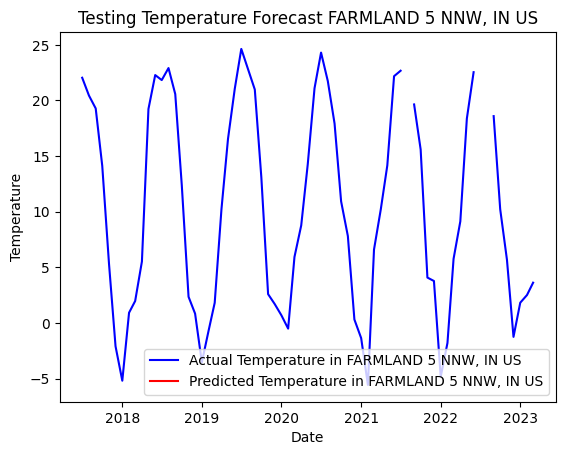

In [240]:
# Vorbereiten der Testdaten
inputs = df[len(df) - len(test) - look_back:].values
inputs = scaler.transform(inputs)
X_test = []
for i in range(look_back, len(inputs)):
    X_test.append(inputs[i-look_back:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Vorhersage der Temperaturen
predicted = model.predict(X_test)
predicted = scaler.inverse_transform(predicted)

# Plotten der Ergebnisse
plt.plot(test.index, test['temp'], color='blue', label='Actual Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(test.index, predicted, color='red', label='Predicted Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Testing Temperature Forecast '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

Prognose auf Zukunft anwenden

In [237]:



predicted=None
df_future=df[-look_back:]
prediction_period=60 #months
results = np.zeros(shape=(prediction_period, 1))
last_known_dateindex=df_future.iloc[[-1]].index

for i in range(0,prediction_period):
  F_test = []
  inputs=scaler.transform(df_future[-look_back:].values)
  F_test.append(inputs)
  F_test= np.array(F_test)
  F_test = np.reshape(F_test, (F_test.shape[0], F_test.shape[1], 1))
  # Vorhersage der Temperaturen n=1
  predicted = model.predict(F_test)
  predicted = scaler.inverse_transform(predicted)
  predicted
  results[i]=predicted

  # add predicted element to df_future
  next_date = last_known_dateindex + pd.DateOffset(months=i+1)
  df_future=pd.concat([df_future,pd.DataFrame({'temp':predicted[0]}, index=next_date)])
  print("hier:"+str(next_date[0]))

results

1/1 [==============================] - 0s 23ms/step
hier:2023-04-01 00:00:00
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2023-05-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2023-06-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2023-07-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2023-08-01 00:00:00
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 30ms/step
hier:2023-09-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2023-10-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2023-11-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2023-12-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 23ms/step
hier:2024-01-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2024-02-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2024-03-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 28ms/step
hier:2024-04-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2024-05-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2024-06-01 00:00:00
1/1 [==============================] - ETA: 0s

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 31ms/step
hier:2024-07-01 00:00:00
1/1 [==============================] - 0s 34ms/step
hier:2024-08-01 00:00:00
1/1 [==============================] - 0s 28ms/step
hier:2024-09-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2024-10-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
hier:2024-11-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2024-12-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2025-01-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2025-02-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 25ms/step
hier:2025-03-01 00:00:00
1/1 [==============================] - 0s 30ms/step
hier:2025-04-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2025-05-01 00:00:00
1/1 [==============================] - 0s 23ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2025-06-01 00:00:00
1/1 [==============================] - 0s 28ms/step
hier:2025-07-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2025-08-01 00:00:00
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2025-09-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2025-10-01 00:00:00
1/1 [==============================] - 0s 23ms/step
hier:2025-11-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2025-12-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step
hier:2026-01-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2026-02-01 00:00:00
1/1 [==============================] - 0s 23ms/step
hier:2026-03-01 00:00:00
1/1 [==============================] - 0s 22ms/step
hier:2026-04-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 22ms/step
hier:2026-05-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2026-06-01 00:00:00
1/1 [==============================] - 0s 29ms/step
hier:2026-07-01 00:00:00
1/1 [==============================] - 0s 28ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2026-08-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2026-09-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2026-10-01 00:00:00
1/1 [==============================] - 0s 24ms/step
hier:2026-11-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 27ms/step
hier:2026-12-01 00:00:00
1/1 [==============================] - 0s 28ms/step
hier:2027-01-01 00:00:00
1/1 [==============================] - 0s 33ms/step
hier:2027-02-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 29ms/step
hier:2027-03-01 00:00:00
1/1 [==============================] - 0s 30ms/step
hier:2027-04-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2027-05-01 00:00:00
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2027-06-01 00:00:00
1/1 [==============================] - 0s 28ms/step
hier:2027-07-01 00:00:00
1/1 [==============================] - 0s 26ms/step
hier:2027-08-01 00:00:00
1/1 [==============================] - 0s 27ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


hier:2027-09-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2027-10-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2027-11-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 0s 32ms/step
hier:2027-12-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2028-01-01 00:00:00
1/1 [==============================] - 0s 25ms/step
hier:2028-02-01 00:00:00
1/1 [==============================] - 0s 27ms/step
hier:2028-03-01 00:00:00


/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan]])

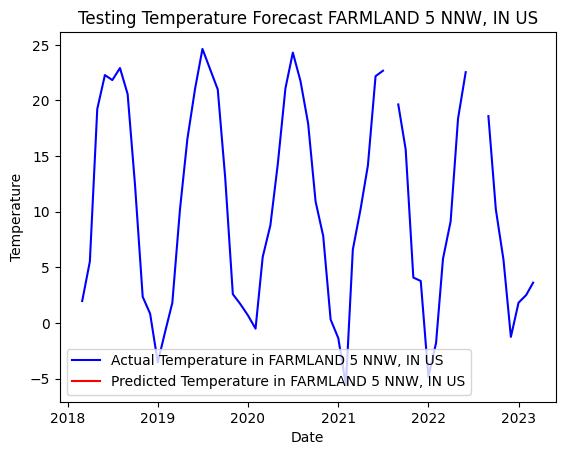

In [238]:


# Plotten der Ergebnisse
plt.plot(df_future[:look_back].index, df_future[:look_back], color='blue', label='Actual Temperature in '+OBSERVATION_LOCATION_NAME)
plt.plot(df_future[look_back:].index, df_future[look_back:], color='red', label='Predicted Temperature in '+OBSERVATION_LOCATION_NAME)
plt.title('Testing Temperature Forecast '+OBSERVATION_LOCATION_NAME)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

test